In [ ]:
from google.colab import drive
drive.mount('/content/drive') # Mount with Google Drive

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/22Project/

/content/drive/MyDrive/22Project


In [ ]:
ls

 DataFlow_thruput.csv  'Traffic Estimation'
 newDataset.csv        'Traffic Estimation with dataflow.ipynb'
 packetFlow.csv


In [ ]:
#MODULES THAT WILL Be USED
from sklearn.model_selection import train_test_split # To seperate train set and test set
from sklearn.linear_model import LinearRegression # To use linear regression
from sklearn.preprocessing import PolynomialFeatures
import numpy as np # for linear algebra
import pandas as pd # data processing, CSV file I/O
import matplotlib.pyplot as plt # to show data scatter, pgraph
import seaborn as sns
%matplotlib inline

---

# (BEFORE) Extract each packet's information (not flow)

In [ ]:
filename = '/content/drive/MyDrive/22Project/newDataset.csv' # This file has each packet's info not flow.
pktData = pd.read_csv(filename, delimiter=',', encoding = "ISO-8859-1", nrows = 2000) # read .csv file
# 너무 많아서 2000개만 선정.
pktData.dataframeName = 'newDataset.csv'
nRow, nCol = pktData.shape # number of row and column
print(f'There are {nRow} rows and {nCol} columns')

There are 2000 rows and 11 columns


In [ ]:
# captured counts graphs for each column data (except Number, Info, Time)
def distributionGraphPerColumn(df, nGraphShown, nGraphPerRow):
    # filtering
    nunique = df.nunique() # nunique : 각 열마다 겹치지 않는 속성의 개수를 센다.
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 182]] 

    nRow, nCol = df.shape # 유용한 column의 행과 열
    columnNames = list(df) # 각 열의 이름 추출
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [ ]:
pktData.head(5) # 위에 5개 정보 예시로 보이기

,No.,Timestamp,Source IP,Destination IP,Source Port,Destination Port,Protocol,Length,Time,Time since previous frame,Info
0,1,"Nov 20, 2022 19:30:04.006900000 WIT",192.168.0.38,66.22.228.211,51186.0,50001.0,UDP,1220,0.000000,0.000000,51186 > 50001 Len=1178
1,2,"Nov 20, 2022 19:30:04.006928000 WIT",192.168.0.38,66.22.228.211,51186.0,50001.0,UDP,1220,0.000028,0.000028,51186 > 50001 Len=1178
2,3,"Nov 20, 2022 19:30:04.006930000 WIT",192.168.0.38,66.22.228.211,51186.0,50001.0,UDP,1220,0.000030,0.000002,51186 > 50001 Len=1178
3,4,"Nov 20, 2022 19:30:04.006940000 WIT",192.168.0.38,66.22.228.211,51186.0,50001.0,UDP,1220,0.000040,0.000010,51186 > 50001 Len=1178
4,5,"Nov 20, 2022 19:30:04.006949000 WIT",192.168.0.38,66.22.228.211,51186.0,50001.0,UDP,1220,0.000049,0.000009,51186 > 50001 Len=1178


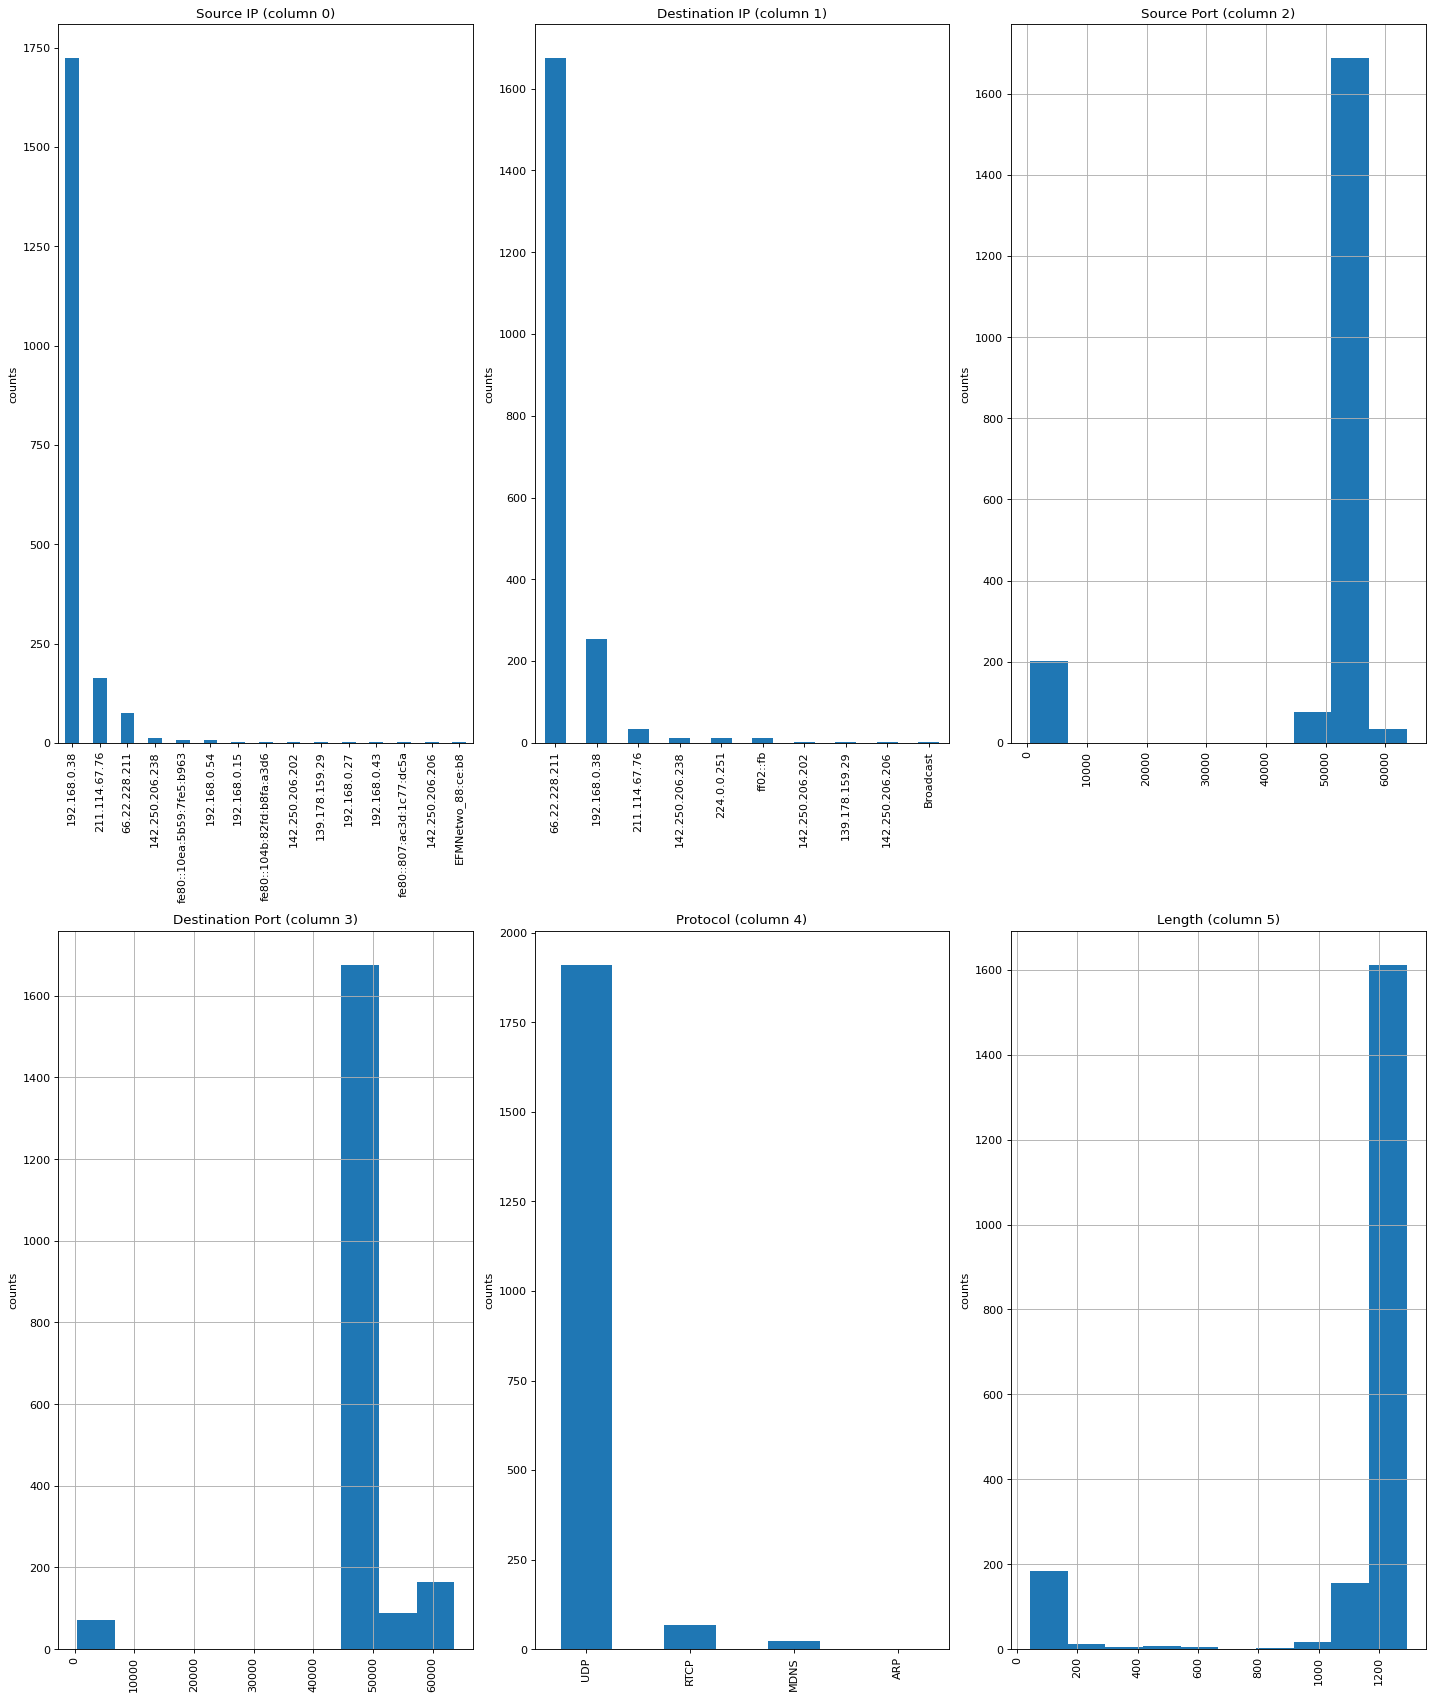

In [ ]:
distributionGraphPerColumn(pktData, 6, 3)



---

# Extract Packet's Flow Data and Preprocessing

Fill NAN value in 0 for every column -> NAN value disturb model learning


In [ ]:
# DATA EXTRACT

flowFilename = '/content/drive/MyDrive/22Project/DataFlow_thruput.csv' 
# This is packet's flow data from wireshark conversations.
# I copied and store in csv file.
# This has S/D IP, Port, Protocol(UDP or TCP), Packet bytes (In flow), throughput(S->D, D->S), Duration
flowData = pd.read_csv(flowFilename, delimiter = ',', encoding = "ISO-8859-1")
flowData.dataframeName = 'DataFlow_thruput.csv'
row, col = flowData.shape
print(f'There are {row} rows and {col} columns')

There are 2929 rows and 16 columns


In [ ]:
# 5 DATA FORM EXAMPLE (TO CHECK COLUMN)

flowData.head(5)

,Source IP,Source Port,Destination IP,Destinatino Port,Protocol,Num_pkts,Bytes,Stream ID,StoD Num_pkts,StoD bytes,DtoS Num_pkts,DtoS bytes,Captured Time,Duration,StoD bits/sec,DtoS bits/sec
0,192.168.0.38,51186,66.22.228.211,50001,UDP,15776,18012247,0,15115,17936733,661,75514,0.000000,53.536196,2680314.0,11284.0
1,192.168.0.54,5353,224.0.0.251,5353,UDP,315,93246,1,315,93246,0,0,0.060194,5013.060049,148.0,0.0
2,fe80::10ea:5b59:7fe5:b963,5353,ff02::fb,5353,UDP,314,99721,2,314,99721,0,0,0.060195,5013.060049,159.0,0.0
3,192.168.0.15,5353,224.0.0.251,5353,UDP,922,277533,3,922,277533,0,0,0.162717,3204.244787,692.0,0.0
4,fe80::104b:82fd:b8fa:a3d6,5353,ff02::fb,5353,UDP,924,296433,4,924,296433,0,0,0.162717,3204.244788,740.0,0.0


In [ ]:
flowData.isna().sum() # Count NAN value in each column

Source IP             0
Source Port           0
Destination IP        0
Destinatino Port      0
Protocol              0
Num_pkts              0
Bytes                 0
Stream ID             0
StoD Num_pkts         0
StoD bytes            0
DtoS Num_pkts         0
DtoS bytes            0
Captured Time         0
Duration              0
StoD bits/sec       499
DtoS bits/sec       499
dtype: int64

In [ ]:
# Fill with 0 where column that has NAN value
flowData['StoD bits/sec'] = flowData['StoD bits/sec'].fillna(0) 
flowData['DtoS bits/sec'] = flowData['DtoS bits/sec'].fillna(0)

# throughput per time [bits/sec]
- 내 컴퓨터에서 발생하는 모든 throughput을 계산
- 첫 flow의 시작 시간부터, 마지막 flow의 시간까지 측정.
- 각 flow는 duration이 존재. 이 duration은 [sec]
- flow시작 ~ duration이 끝나면 해당 throughput은 삭제해줘야함.
- duration 안에 새로운 flow가 시작 : throughput을 더해준다.

In [ ]:
flowData.head(5)

,Source IP,Source Port,Destination IP,Destinatino Port,Protocol,Num_pkts,Bytes,Stream ID,StoD Num_pkts,StoD bytes,DtoS Num_pkts,DtoS bytes,Captured Time,Duration,StoD bits/sec,DtoS bits/sec
0,192.168.0.38,51186,66.22.228.211,50001,UDP,15776,18012247,0,15115,17936733,661,75514,0.000000,53.536196,2680314.0,11284.0
1,192.168.0.54,5353,224.0.0.251,5353,UDP,315,93246,1,315,93246,0,0,0.060194,5013.060049,148.0,0.0
2,fe80::10ea:5b59:7fe5:b963,5353,ff02::fb,5353,UDP,314,99721,2,314,99721,0,0,0.060195,5013.060049,159.0,0.0
3,192.168.0.15,5353,224.0.0.251,5353,UDP,922,277533,3,922,277533,0,0,0.162717,3204.244787,692.0,0.0
4,fe80::104b:82fd:b8fa:a3d6,5353,ff02::fb,5353,UDP,924,296433,4,924,296433,0,0,0.162717,3204.244788,740.0,0.0


In [ ]:
thruputArr = np.array([]) # Y축이 될 배열
starttimeArr = np.array([]) # X축이 될 배열

eachThruput = np.array([])
eachEndtimeArr = np.array([])
currentThruput = 0.0

'''
1. 해당 flow의 throughput을 배열에 넣기 (A -> B 에서 sending bits만 생각한다.) : eachEndtimeArr[]
2. 해당 flow의 종료 시간을 배열에 넣기 : eachThruput[]
3. 현재 통용되고 있는 throughput을 변수에 더하기
4. 해당 flow의 captured 시간보다 더 전에 종료 시간이 존재하면 해당 throughput은 삭제
   그렇지 않은 index는 해당 정보를 다른 배열에 복사 cpTP[], cpTime[]
5. eachEndtimeArr[] = cpTime[], eachThruput[] = cpTP[]
'''

for rowIdx, row in flowData.iterrows():
  eachEndtimeArr = np.append(eachEndtimeArr, (row['Captured Time']+row['Duration'])) # 해당 row flow가 끝나는 시간 측정
  eachThruput = np.append(eachThruput, row['StoD bits/sec']) # 해당 row flow의 throughput 측정 (Source to Destination)

  currentThruput += row['StoD bits/sec'] # 이전 flow의 thruput에 현재 Row thruput을 더한 값. = 내 노트북에서 현재 일어나고 있는 throughput

  starttimeArr = np.append(starttimeArr, row['Captured Time'])
  # start time of the flow (to scatter graph) - x축으로 사용

  cpTP = np.array([])
  cpTime = np.array([])
  # 이전 시간 flow는 빼고 생각할 거니까, 그것을 제외하고 갱신할 list 선언
  for i in range(len(eachEndtimeArr)): # endtimeArr를 비교해줄 것임.
    if eachEndtimeArr[i] < row['Captured Time']: # 현재 flow의 시간보다 전에 끝나는 시간을 갖고 있는 flow는,
      currentThruput -= eachThruput[i] # 현재 thruput에서 그때의 flow를 제거.
    else: # 만약 현재 flow 시간보다 더 오래 지속된다면,
      cpTP = np.append(cpTP, eachThruput[i]) # 그 flow의 thruput과 time의 정보는 유지한다.
      cpTime = np.append(cpTime, eachEndtimeArr[i])
      # cpTime = eachEndtimeArr[i] // logical error line

  # 삭제된 flow를 제외한 현재 on-flight 중인 flow들의 data 복사
  eachThruput = cpTP 
  eachEndtimeArr = cpTime

  thruputArr = np.append(thruputArr, currentThruput)

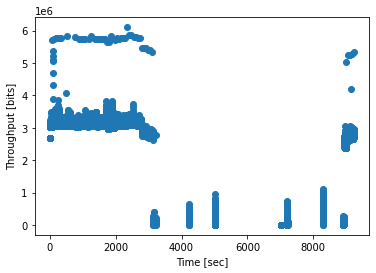

In [ ]:
plt.xlabel('Time [sec]')
plt.ylabel('Throughput [bits]')
plt.scatter(starttimeArr, thruputArr)

In [ ]:
# 위에서 test set과 train set을 분리.
train_input, test_input, train_target, test_target = train_test_split(
    starttimeArr, thruputArr, random_state=42)

# 각 입력은 2차원 배열로 선언.
train_input = train_input.reshape(-1,1)
test_input = test_input.reshape(-1,1)

**2차식 선형회귀**

In [ ]:
x = np.c_[train_input, train_input**2]
y = train_target

model2 = LinearRegression()
model2.fit(x, y)

model2.coef_, model2.intercept_

(array([-8.34360252e+02,  6.74455414e-02]), 3870614.439676348)

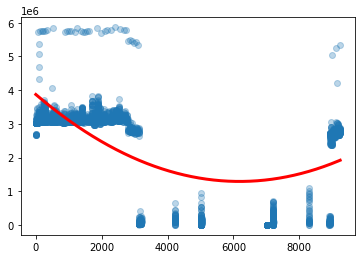

In [ ]:
xs = np.arange(1,max(train_input)+1)
ys = xs*model2.coef_[0] + (xs**2)*model2.coef_[1] + model2.intercept_


plt.scatter(train_input, train_target, alpha=0.3)
plt.plot(xs,ys,'r-',lw=3)

In [ ]:
# 평가 방법 1 r-square 모듈 이용하기
from sklearn.metrics import r2_score
r2_score(test_target, model2.predict(test_input))

ValueError: ignored

In [ ]:
# 평가 방법 2 수기로 r-square 계산하기
y_pred = model2.predict(test_input)

# 잔차 구하기
y_mean = np.mean(test_target) # y 평균값

# $\sum(y 예측값 - y 평균값)^2$ = 예측값에 대한 편차
nomerator = np.sum(np.square(test_target - y_pred)) 

# $sum(y 관측값 - y 평균값)^2$
denominator = np.sum(np.square(test_target - y_mean))
r2 = 1 - nomerator / denominator
r2

ValueError: ignored

In [ ]:
# 추가
multivalue = PolynomialFeatures(degree=2)

**3차식 선형회귀**

In [ ]:
x3 = np.c_[train_input, train_input**2, train_input**3]
y3 = train_target

model3 = LinearRegression()
model3.fit(x3, y3)

model3.coef_, model3.intercept_

(array([ 7.66962200e+02, -4.78895897e-01,  4.26051016e-05]),
 3063045.1087283767)

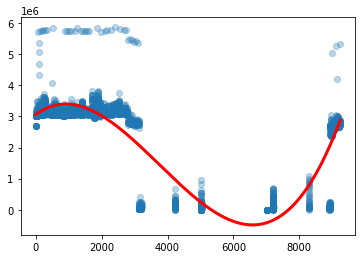

In [ ]:
xs3 = np.arange(1,max(train_input)+1)
ys3 = xs3*model3.coef_[0] + (xs3**2)*model3.coef_[1] + (xs3**3)*model3.coef_[2] + model3.intercept_

plt.scatter(train_input, train_target, alpha=0.3)
plt.plot(xs3,ys3,'r-',lw=3)

In [ ]:
y_pred = model3.predict(test_input)

# 잔차 구하기
y_mean = np.mean(test_target) # y 평균값

# $\sum(y 예측값 - y 평균값)^2$ = 예측값에 대한 편차
nomerator = np.sum(np.square(test_target - y_pred)) 

# $sum(y 관측값 - y 평균값)^2$
denominator = np.sum(np.square(test_target - y_mean))
r2 = 1 - nomerator / denominator
r2

TypeError: ignored